# Compass Postprocessing

To demonstrate downstream analysis (postprocessing) of Compass results, we provide a python notebook. The notebook demonstrates a differential analysis pipeline comparing two groups of cells and replicates figures from our paper paper analyzing Th17 cell metabolism.

The presentation of the algorithm assumes a single-cell data set. For the built in microclustering of Compass, we provide a short python notebook on how to analyze the clusters. However, you may choose to group cells together externally (e.g. via metacell or micropooling) to reduce computational overhead. You may also apply Compass to bulk transcriptome data sets (e.g. bulk RNA-seq or microarray data sets) if there are enough observations (samples) to gain statistical power.

## Requirements

All of the required python packages can be installed using a cell at the start of the notebook. To install the required python packages, you can uncomment the “install_reqs()” call.

## Usage

This notebook gives a small demo of analyzing the results of the compass algorithm and replicates figures 2E and 2C from the paper.

The example in the notebook uses metadata that would come from knowledge of what cells/samples were sequenced as well as the output of a Compass run.

The notebook can be run top down and the main section uses Wilcoxon rank sum to test for differential predicted activity of single reactions between pathogenic Th17 (Th17p) and non-pathogenic Th17 (Th17n) cells. This differs slightly from the paper’s version which tests for predicted differential activity meta-reactions instead, and the code for that is at the end of the notebook.

The notebook can be modified to analyze other datasets by providing a different input of Compass results and relevant cell metadata. But of course, this example is intended to be a starting point and you may conduct other analyses, replace the Wilcoxon rank sum test or the Cohen’s D effect size with your favorite statistical test, and/or add other preprocessing steps depending on how your data looks and what are your research questions.

In [1]:
def install_reqs():
  !pip install pandas
  !pip install "matplotlib>=3.4"
  !pip install numpy
  !pip install statsmodels
  !pip install scipy
#install_reqs()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from compass_analysis import cohens_d, wilcoxon_test, get_reaction_consistencies, get_metareactions, labeled_reactions, amino_acid_metab

/home/eecs/charleschien101/anaconda3/envs/cplex/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from matplotlib import __version__ as matplotlibversion
if matplotlibversion < "3.4":
    print("Matplotlib versions older than 3.4 may not be able to generate figure 2E, as they do not support alpha arrays")

The file "extdata/Th17/reactions.tsv" is the outputs of a compass run and "extdata/Th17/cell_metadata.csv" is cell metadata, in this case it is only used to know the condition of the Th17 cells (pathogenic vs. non-pathogenic).

In [4]:
reaction_penalties = pd.read_csv("extdata/Th17/reactions.tsv", sep="\t", index_col = 0) 

In [5]:
cell_metadata = pd.read_csv("extdata/Th17/cell_metadata.csv", index_col = 0)

In [6]:
# pathogenic Th17 = Th17p; non-pathogenic Th17 = Th17n

Th17p_cells = cell_metadata.index[cell_metadata['cell_type'] == 'Th17p']
Th17n_cells = cell_metadata.index[cell_metadata['cell_type'] == 'Th17n']

The reaction metadata for RECON2 is stored here. We'll be using the confidence scores and the subsystem groupings to filter out reactions and group them for analysis.

In [7]:
reaction_metadata = pd.read_csv("extdata/RECON2/reaction_metadata.csv", index_col = 0) 

Here is one example of a row for the reaction metadata:

In [8]:
reaction_metadata.loc[['r0281']]

,reaction_name,formula,associated_genes,subsystem,EC_number,confidence
reaction_no_direction,,,,,,
r0281,Putrescine:oxygen oxidoreductase (deaminating)...,1.00 * Water [e] + 1.00 * O2 [e] + 1.00 * Putr...,AOC1,Methionine and cysteine metabolism,1.4.3.6,0.0


The numbers in the reactions tsv correspond to penalties for each reaction per cell, so we take the negative log to get scores that are higher the more active the reaction is predicted to be. This also drops reactions that are close to constant and therefore not informative for the comparison.

In [9]:
#This function is repeated here for clarity
def get_reaction_consistencies(compass_reaction_penalties, min_range=1e-3):
    """
        Converts the raw penalties outputs of compass into scores per reactions where higher numbers indicate more activity
    """
    df = -np.log(compass_reaction_penalties + 1)
    df = df[df.max(axis=1) - df.min(axis=1) >= min_range]
    df = df - df.min().min()
    return df

In [10]:
reaction_consistencies = get_reaction_consistencies(reaction_penalties)

We use the unpaired Wilcoxon rank-sum test (equivlanet to the Mann–Whitney U test) to analyze which reactions are predicted to be more active in pathogenic Th17p cells compared to the non-pathogenic Th17n cells. Positive values indicate higher potential activity in Th17p. 

In [11]:
wilcox_results = wilcoxon_test(reaction_consistencies, Th17p_cells, Th17n_cells)
wilcox_results['metadata_r_id'] = ""
for r in wilcox_results.index:
    if r in reaction_metadata.index:
        wilcox_results.loc[r, 'metadata_r_id'] = r
    elif r[:-4] in reaction_metadata.index:
        wilcox_results.loc[r, 'metadata_r_id'] = r[:-4]
    else:
        print("Should not occur")

Next we join the metadata to the reactions in a new dataframe W, so that we can filter out non-core reactions. More specifically, we remove reactions with confidence other than 0 or 4 (4 = most confident; 0 = unassigned confidence) and filter out reactions in the citric acid cycle subsystem which are outside of the mitochondria.

In [12]:
W = wilcox_results.merge(reaction_metadata, how='left', 
                         left_on='metadata_r_id', right_index=True, validate='m:1')
W = W[W['confidence'].isin([0,4])]
W = W[~W['EC_number'].isna()]
W.loc[(W['formula'].map(lambda x: '[m]' not in x)) & (W['subsystem'] == "Citric acid cycle"), 'subsystem'] = 'Other'

Here is one example of a row of the reuslting dataframe for a reaction:

In [13]:
wilcox_results.loc[['r0281_pos']]

,wilcox_stat,wilcox_pval,cohens_d,adjusted_pval,metadata_r_id
r0281_pos,9269.0,0.085969,-0.221507,0.153082,r0281


The "_neg" or "_pos" suffixes indicate one direction of a bidirectional reaction. The "_pos" direction indicates positive flux through the reaction. For this example reaction it indicates water, oxygen, and putrescine are being consumed by this reaction to produce ammonium, hyrodgen peroxide, and 4-Aminobutanal.

In [14]:
reaction_metadata.loc['r0281']['formula']

'1.00 * Water [e] + 1.00 * O2 [e] + 1.00 * Putrescine [e] --> 1.00 * Ammonium [e] + 1.00 * Hydrogen peroxide [e] + 1.00 * 4-Aminobutanal [e]\nAOC1'

### Optional: Metareaction analysis
[Metareactions](#metareactions-target) are used in the paper rather than single reaction analysis and the section at the bottom of this notebook performs the same analysis using reactions clustered into metareactions.

(figure-2c-target)=
### Figure 2C replication

In [15]:
def plot_differential_scores(data, title, c):
    plt.figure(figsize=(10,10))
    axs = plt.gca()
    axs.scatter(data['cohens_d'], -np.log10(data['adjusted_pval']), c=c)
    axs.set_xlabel("Cohen's d", fontsize=16)
    axs.set_ylabel("-log10 (Wilcoxon-adjusted p)", fontsize=16)
    #Everything after this should be tweaked depending on your application
    axs.set_xlim(-2.2, 2.2)
    axs.axvline(0, dashes=(3,3), c='black')
    axs.axhline(1, dashes=(3,3), c='black')
    axs.set_title(title, fontdict={'fontsize':20})
    axs.annotate('', xy=(0.5, -0.08), xycoords='axes fraction', xytext=(0, -0.08), 
            arrowprops=dict(arrowstyle="<-", color='#348C73', linewidth=4))
    axs.annotate('Th17p', xy=(0.75, -0.12), xycoords='axes fraction', fontsize=16)
    axs.annotate('', xy=(0.5, -0.08), xycoords='axes fraction', xytext=(1, -0.08), 
            arrowprops=dict(arrowstyle="<-", color='#E92E87', linewidth=4))
    axs.annotate('Th17n', xy=(0.25, -0.12), xycoords='axes fraction', fontsize=16)
    for r in data.index:
        if r in labeled_reactions:
            x = data.loc[r, 'cohens_d']
            y = -np.log10(data.loc[r, 'adjusted_pval'])
            offset = (20, 0)
            if x < 0:
                offset = (-100, -40)
            axs.annotate(labeled_reactions[r], (x,y), xytext = offset, 
                         textcoords='offset pixels', arrowprops={'arrowstyle':"-"})

In [16]:
filtered_data = pd.concat([W[W['subsystem'] == "Glycolysis/gluconeogenesis"],
             W[W['subsystem'] == "Citric acid cycle"],
            W[W['subsystem'].isin(amino_acid_metab)],
           W[W['subsystem'] == "Fatty acid oxidation"]])

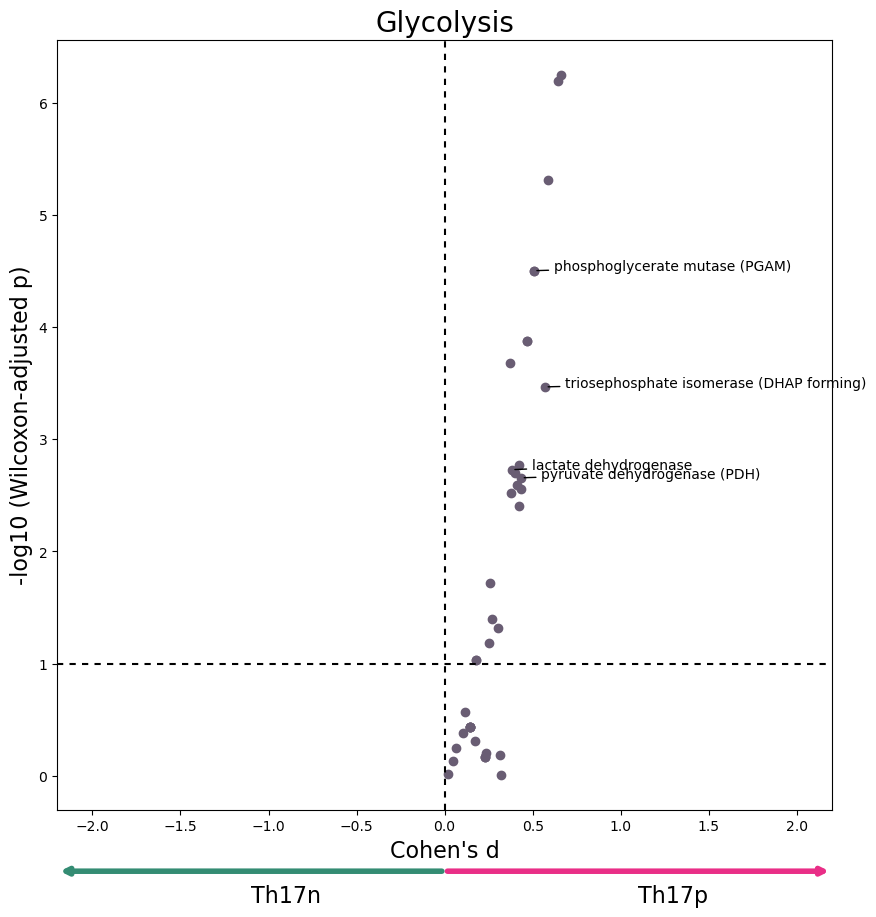

In [18]:
data = W[W['subsystem'] == "Glycolysis/gluconeogenesis"]
plot_differential_scores(data, title='Glycolysis', c="#695D73")

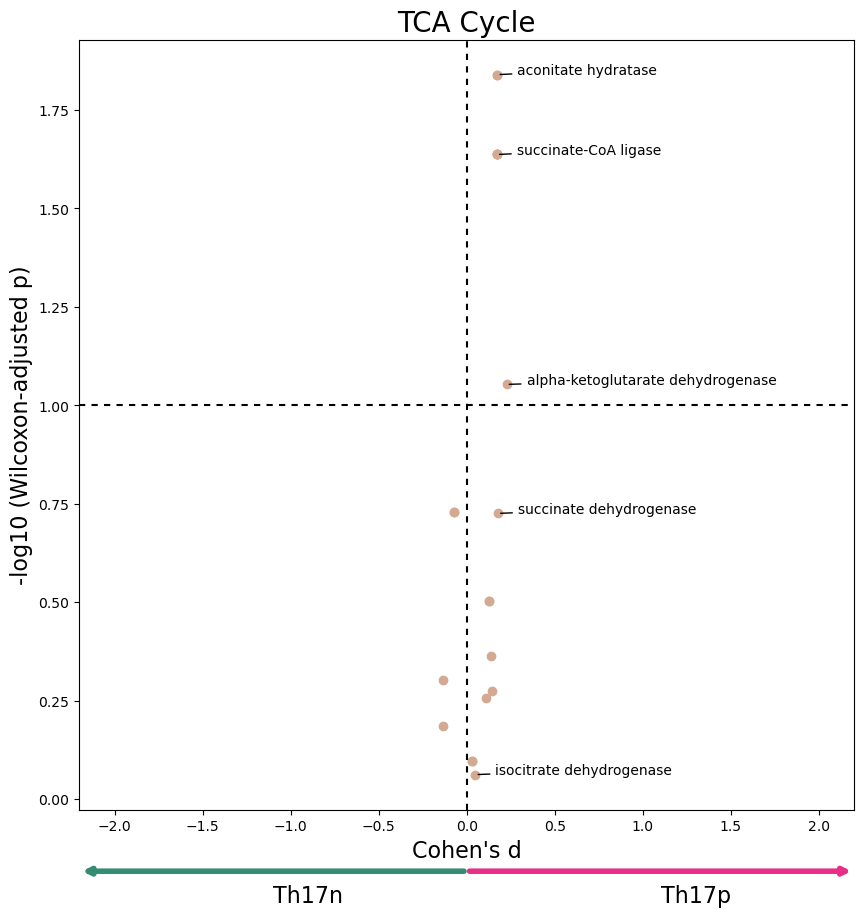

In [20]:
data = W[W['subsystem'] == "Citric acid cycle"]
plot_differential_scores(data, title="TCA Cycle", c="#D3A991")

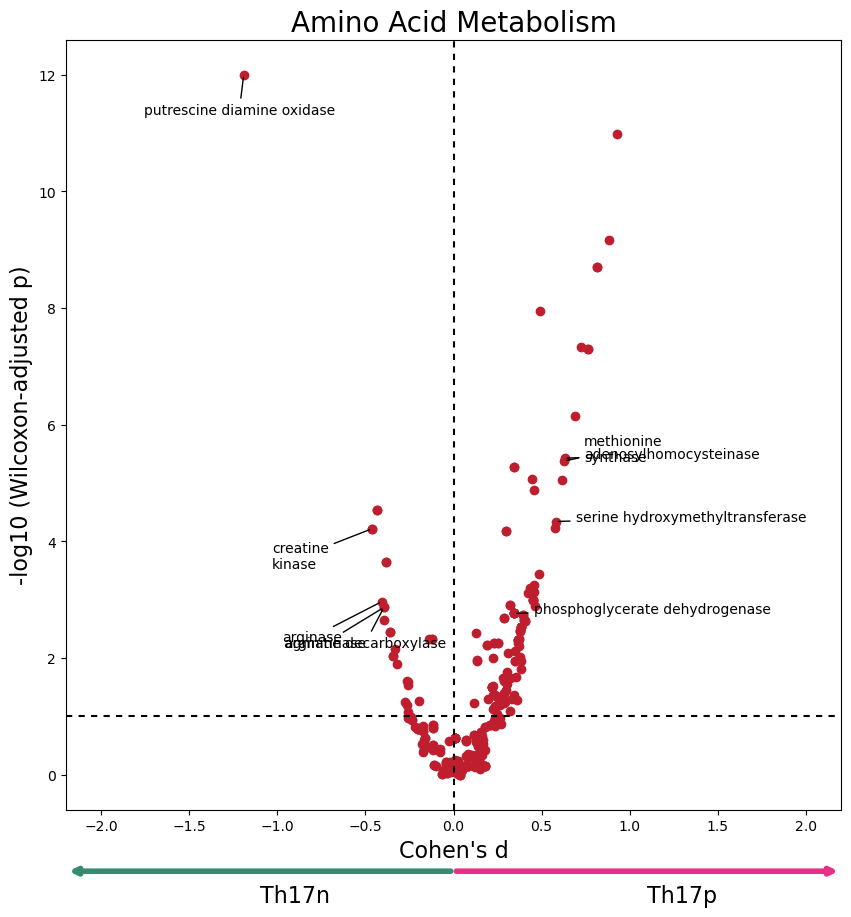

In [22]:
data = W[W['subsystem'].isin(amino_acid_metab)].copy()
data['adjusted_pval'] = data['adjusted_pval'].clip(1e-12)
plot_differential_scores(data, "Amino Acid Metabolism", c="#BF1E2E")

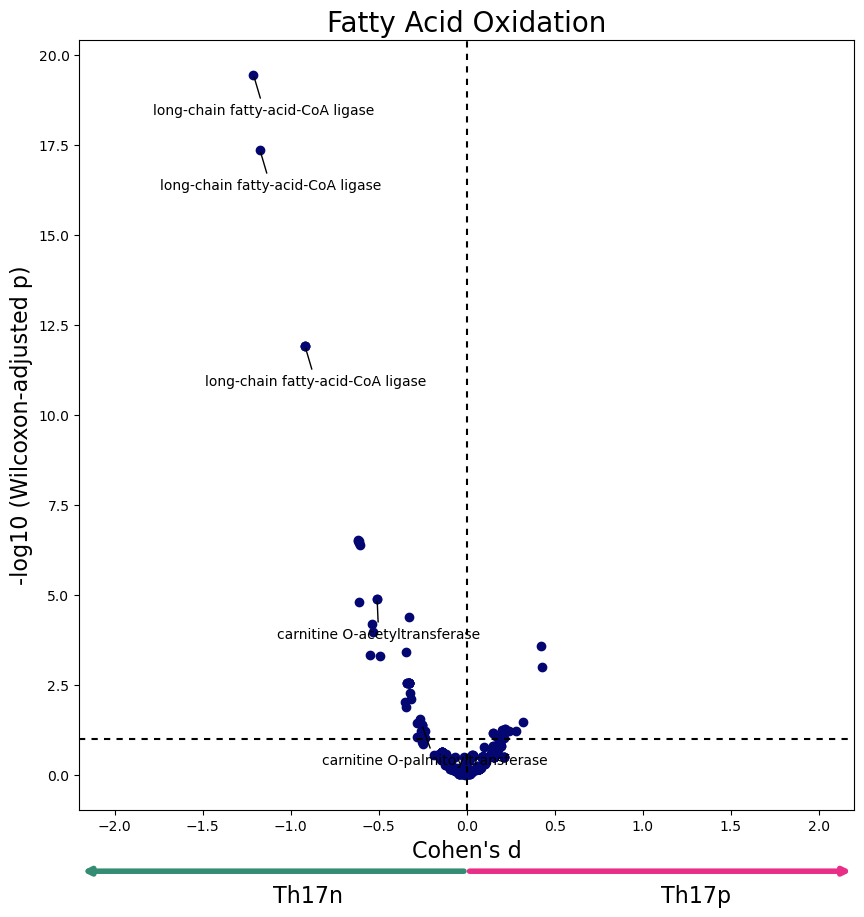

In [23]:
data = W[W['subsystem'] == "Fatty acid oxidation"]
plot_differential_scores(data, "Fatty Acid Oxidation", c="#040772")

(figure-2e-target)=
### Figure 2E replication

In [24]:
data = W[~W['subsystem'].isin(["Miscellaneous", "Unassigned"])]
data = data[~data['subsystem'].map(lambda x: "Transport" in x or "Exchange" in x or x == "Other")]
items, counts = np.unique(data['subsystem'], return_counts=True)
items = [items[i] for i in range(len(items)) if counts[i] > 5] #filter(n() > 5) %>%
data = data[data['subsystem'].isin(items)]

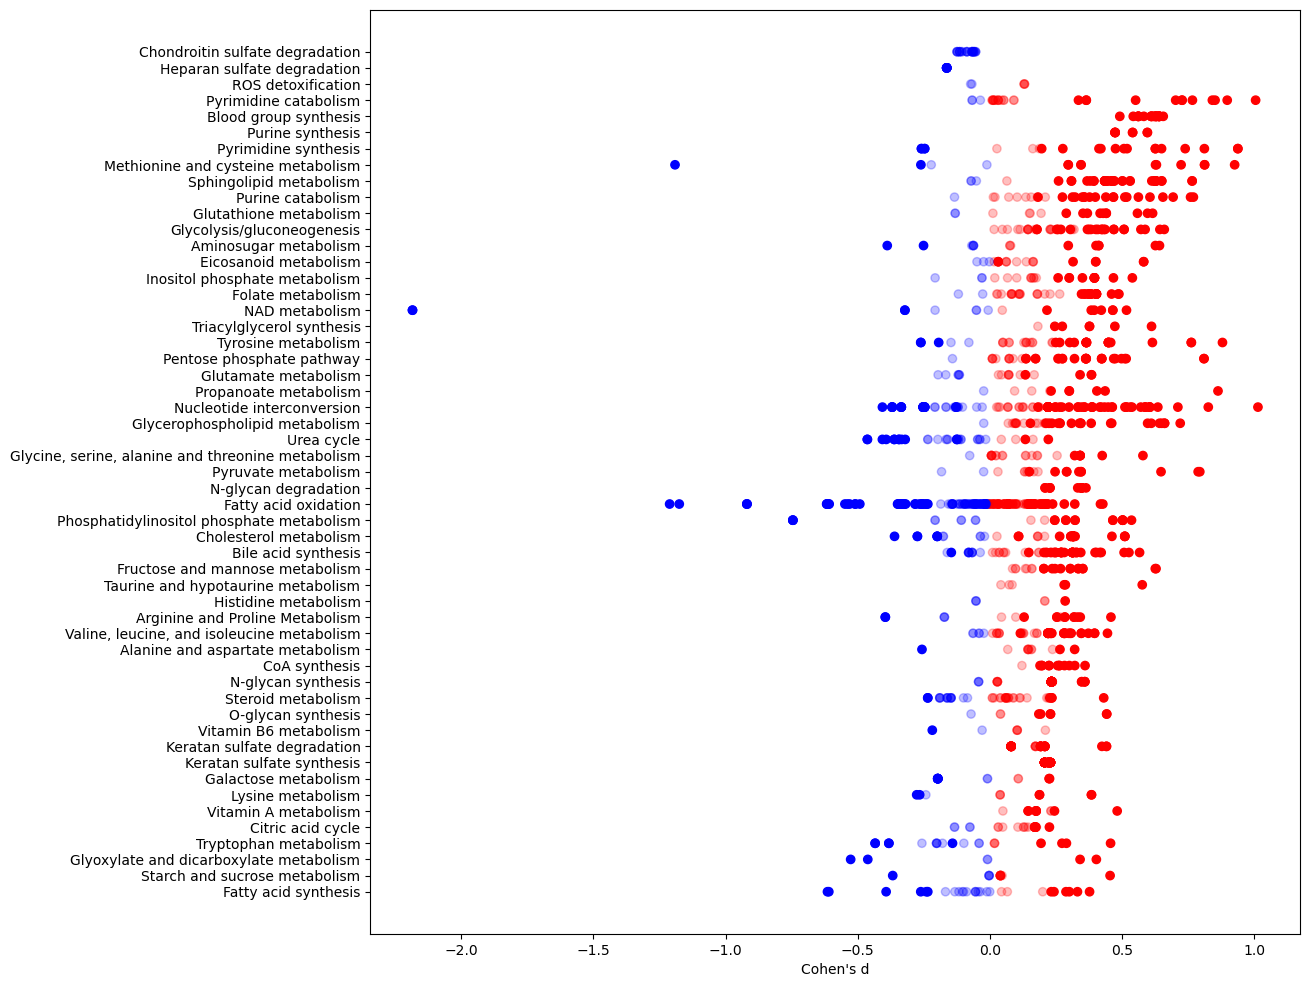

In [26]:
plt.figure(figsize=(12,12))
axs = plt.gca()
#Sorts the reactions for plotting
d = data[data['adjusted_pval'] < 0.1].groupby('subsystem')['cohens_d'].median().abs()
axs.scatter(d[d.argsort], d[d.argsort].index, alpha=0)
color = data['cohens_d'].map(lambda x: 'r' if x >= 0 else 'b')
alpha = data['adjusted_pval'].map(lambda x: 1.0 if x < 0.1 else 0.25)
axs.scatter(data['cohens_d'], data['subsystem'], c=color, alpha=alpha)
axs.set_xlabel("Cohen's d")
plt.show()

(metareactions-target)=
### Metareactions
The following section analyzes the the results by clustering the reactions into metareactions, matching with the manuscript as closely as possible (up to Python vs R). It will be repeating the previous analysis for the clustered reactions instead of single reactions.

In [27]:
reaction_penalties = pd.read_csv("extdata/Th17/reactions.tsv", sep="\t", index_col = 0)
reaction_penalties[reaction_penalties <= 1e-4] = 0
reaction_penalties = reaction_penalties[np.all(reaction_penalties != 0, axis=1)]

In [28]:
reaction_penalties = reaction_penalties[reaction_penalties.max(axis=1) - reaction_penalties.min(axis=1) != 0]

We group reactions into metareactions using heirarchical clustering as detailed in the manuscript.

In [29]:
meta_rxns_map = get_metareactions(reaction_penalties)
meta_rxns = reaction_penalties.join(pd.DataFrame(meta_rxns_map, columns=["meta_rxn_id"], index = reaction_penalties.index)).groupby("meta_rxn_id").mean()

In [30]:
meta_rxn_consistencies = get_reaction_consistencies(meta_rxns)

In [31]:
wilcox_meta_rxn_results = wilcoxon_test(meta_rxn_consistencies, Th17p_cells, Th17n_cells)

Now each row of the dataframe contains the results of the statistical tests for each metareaction:

In [33]:
wilcox_meta_rxn_results.iloc[0:1]

,wilcox_stat,wilcox_pval,cohens_d,adjusted_pval
meta_rxn_id,,,,
1,4172.0,7.900994e-19,-1.261458,1.360551e-16


Next the metareaction results dataframe is expanded out to each reaction that makes up the metareactions so that the metadata can be joined to it and used to generate plots.

In [34]:
wilcox_meta_rxn_expanded = pd.DataFrame(index=reaction_penalties.index, columns=wilcox_meta_rxn_results.columns)
for i in range(len(wilcox_meta_rxn_expanded.index)):
    if (meta_rxns_map[i] in wilcox_meta_rxn_results.index):
        wilcox_meta_rxn_expanded.loc[wilcox_meta_rxn_expanded.index[i]] = wilcox_meta_rxn_results.loc[meta_rxns_map[i]]
wilcox_meta_rxn_expanded = wilcox_meta_rxn_expanded.dropna().astype('float64')

In [35]:
wilcox_meta_rxn_expanded['metadata_r_id'] = ""
for r in wilcox_meta_rxn_expanded.index:
    if r in reaction_metadata.index:
        wilcox_meta_rxn_expanded.loc[r, 'metadata_r_id'] = r
    elif r[:-4] in reaction_metadata.index:
        wilcox_meta_rxn_expanded.loc[r, 'metadata_r_id'] = r[:-4]
    else:
        print("Should not occur")

Now each row contains information on a single reaction:

In [37]:
wilcox_meta_rxn_expanded.iloc[0:1]

,wilcox_stat,wilcox_pval,cohens_d,adjusted_pval,metadata_r_id
10FTHF5GLUtl_pos,12939.0,0.000613,0.390921,0.002207,10FTHF5GLUtl


To generate the following figures with the metareactions, simply uncomment the cell below and run it. Then you can generate the figures with the previous cells for [Figure 2C replication](#figure-2c-replication) and [Figure 2E replication](#figure-2e-replication) using the metareaction based data.

In [33]:
#W = wilcox_meta_rxn_expanded.merge(reaction_metadata, how='left', 
#                         left_on='metadata_r_id', right_index=True, validate='m:1')
#W = W[W['confidence'].isin([0,4])]
#W = W[~W['EC_number'].isna()]
#W.loc[(W['formula'].map(lambda x: '[m]' not in x)) & (W['subsystem'] == "Citric acid cycle"), 'subsystem'] = 'Other'